In [1]:
from r3d2 import State, eos_defns
import numpy
from scipy.optimize import brentq
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
gamma = 5/3
eos = eos_defns.eos_gamma_law(gamma)
# rho, v, vt, eps, eos
q_right = State(8.0, -0.2, 0, 2.5, eos)

rhoL = 5.0
vL = 0.0
epsL = 2.0

In [3]:
# TODO: refactor this so use q_L rather than all the other _L quantities
# TODO: check this using the solver to see if it really does give the correct vt_crit
# TODO: this only works in the shock region. See if can extend it to the rarefaction region too?
def find_crit_vt(vt_L, q_R, rho_L, v_L, eps_L, eos, lr_sign=-1):
    """
    Returns vx_L* - vx_R, which should be 0 at the tangential velocity.
    """
    p_L = eos['p_from_rho_eps'](rho_L, eps_L)
    h_L = eos['h_from_rho_eps'](rho_L, eps_L)
    
    # mass flux 
    j2 = (p_L - q_R.p) / ((h_L**2 - q_R.h**2) / (p_L - q_R.p) - 2. * h_L / rho_L)
    
    W_L = 1.0 / numpy.sqrt(1.0 - v_L **2 - vt_L**2)
    
    V_minus = (rho_L**2 * W_L**2 * v_L + lr_sign * j2 * numpy.sqrt(1. + rho_L**2 * W_L**2 * (1. - v_L**2)/j2)) / \
              (rho_L**2 * W_L**2 + j2)
    
    # now use the fact that vx_L* = vx_R, p_L* = p_R to root find 
    
    return (h_L * W_L *v_L + lr_sign * (q_R.p - p_L) / (numpy.sqrt(j2*(1. - V_minus**2)))) / \
           (h_L * W_L + (q_R.p - p_L) * 
                (1. / (rho_L * W_L) + lr_sign * v_L / numpy.sqrt(j2 * (1. - V_minus**2)))) - q_R.v
    

In [4]:
rhoLs = numpy.linspace(4, 6., num=100000)

min_vt = 0.0
max_vt = 0.9999

vts = []

for rho in rhoLs:
    if numpy.isnan(find_crit_vt(min_vt, q_right, rho, vL, epsL, eos)):
        lr_sign = 1
    else:
        lr_sign = -1
    #print(find_crit_vt(min_vt, q_right, rho, vL, epsL, eos, lr_sign))
    #print(find_crit_vt(max_vt, q_right, rho, vL, epsL, eos, lr_sign))
    try:
        crit_vt = brentq(find_crit_vt, min_vt, max_vt, args=(q_right, rho, vL, epsL, eos, lr_sign))
    except ValueError:
        break
    vts.append(crit_vt)

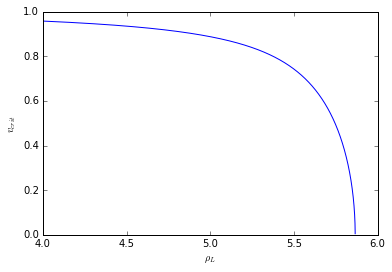

In [5]:
plt.plot(rhoLs[:len(vts)], vts)
plt.xlabel(r'$\rho_L$')
plt.ylabel(r'$v_{crit}$')
plt.show()

In [6]:
# The point where the code blew up should give a good estimate of the value of rho_L when v_crit = 0
rhoLs[len(vts)-1]

5.8654186541865414